In [3]:
import gensim
import pandas as pd

In [59]:
songDF = pd.read_pickle("./songDF_ALL.pickle")

In [87]:
testlyrics =[]
for index,row in songDF.iterrows():
    songs = row['lyrics'].songs
    artist = row['artist']
    for song in songs:
        if song and hasattr(song,'lyrics') and isinstance(song.lyrics,str):
            testlyrics.append(song.lyrics)

In [89]:
songsDict = {}
for index,row in songDF.iterrows():
    songs = row['lyrics'].songs
    artist = row['artist']
    songsDict[artist] = []
    for song in songs:
        if song and hasattr(song,'lyrics') and isinstance(song.lyrics,str):
            songsDict[artist].append(gensim.utils.simple_preprocess(song.lyrics))
    


In [90]:
modelDict = {}
for artist,songs in songsDict.items():
    model = gensim.models.Word2Vec(songs,size=10,window=10,min_count=1,workers=10)
    model.train(songs,total_examples=len(songs),epochs=10)
    modelDict[artist] = model

In [133]:
similarities = {}
for artist,model in modelDict.items():
    vocab = model.wv.vocab.keys()
    similarities[artist] = {}
    for compareArtist,compareModel in modelDict.items():
        if compareArtist is not artist:
            compareVocab = compareModel.wv.vocab.keys()
            sharedVocab = vocab&compareVocab
            similarities[artist][compareArtist] = sharedVocab
    

In [160]:
import numpy as np
artist_sims= {}
for artist1,artist2Dict in similarities.items():
    artist_sims[artist1] = []
    for artist2,words in artist2Dict.items():
        dot_product_list = []
        for word in words:
            vector_artist1 = modelDict[artist1].wv[word]
            vector_artist2 = modelDict[artist2].wv[word]
            wv_dot_product = np.dot(vector_artist1,vector_artist2)
            normalization = np.linalg.norm(vector_artist1)*np.linalg.norm(vector_artist2)
            dot_product_list.append(wv_dot_product/normalization)
            
        artist_sims[artist1].append( (artist2,sum(dot_product_list)/len(dot_product_list)) )
    artist_sims[artist1].sort(key=lambda tup: tup[1])

In [149]:
import matplotlib.pyplot as plt

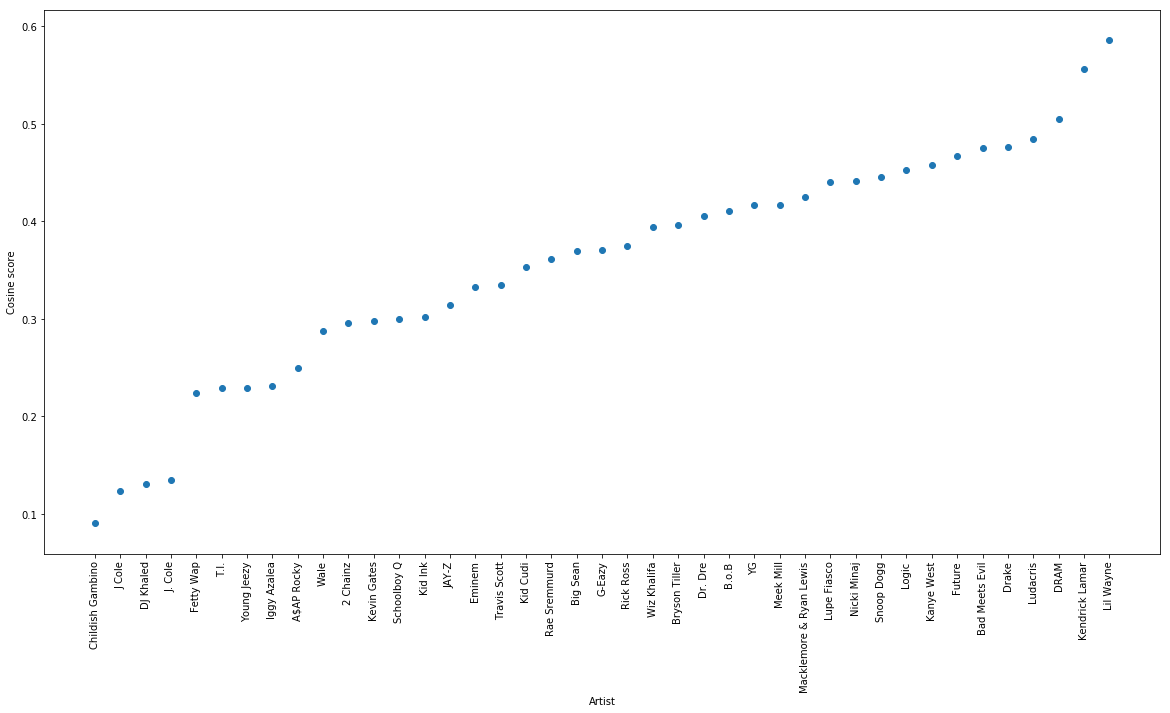

In [169]:
plt.figure(figsize=(20,10))
plt.scatter(*zip(*artist_sims['Post Malone']))
plt.xticks(rotation=90)
plt.ylabel("Cosine score")
plt.xlabel("Artist")
plt.show()